<a href="https://colab.research.google.com/github/isegura/seminarioUPM/blob/main/7_LSTM_WE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long Short Term Memory (LSTM)

In this notebook, we will learn how to use a BiLSTM with pre-trained word embeddings to classify the sentiment of tweets about Covid-10. 


[Kaggle example](https://www.kaggle.com/anubhavsanyal/tensorflow-with-lstm-83-accuracy/notebook)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

## Loading data and vectorization

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
root='drive/My Drive/Colab Notebooks/seminarioUPM/'

# reading the already cleaned data
train_data = pd.read_csv(root+'data/train.csv')
test_data = pd.read_csv(root+'data/test.csv')
# dropping indexes with nan

# training set
index_with_nan = train_data.index[train_data.isnull().any(axis=1)]
train_data.drop(index_with_nan,0, inplace=True)

# testing set
index_with_nan = test_data.index[test_data.isnull().any(axis=1)]
test_data.drop(index_with_nan,0, inplace=True)
print(f'Training instances: {train_data.shape[0]}, and testing instances: {test_data.shape[0]}')

#texts
X_train = train_data.iloc[:,0]
X_test = test_data.iloc[:,0]

#labels
y_train = train_data.iloc[:,1]
y_test = test_data.iloc[:,1]

train_text=X_train.to_numpy()
test_text = X_test.to_numpy()

#converts from a categorial data to a one-hot encoding vector 
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

train_labels = y_train.to_numpy() 
test_labels = y_test.to_numpy() 

import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


MAX_WORDS = 40000
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='OOV')
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

NUM_WORDS=min(len(word_index),MAX_WORDS)
print(NUM_WORDS)

MAX_SEQUENCE_LENGTH=30 #lenght of the input sequences

train_text_sequeces = tokenizer.texts_to_sequences(train_text)
train_text_padded = pad_sequences(train_text_sequeces, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post', truncating='pre') 

test_text_sequeces = tokenizer.texts_to_sequences(test_text)
test_text_padded = pad_sequences(tokenizer.texts_to_sequences(test_text), maxlen=MAX_SEQUENCE_LENGTH, padding = 'post', truncating='pre') 


Mounted at /content/drive/
Training instances: 41087, and testing instances: 3795
30841


### Loading the pre-trained word embedding model and creating the embedding matrix

In [ ]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data
#word_vectors = api.load("glove-twitter-25")

#Other models:
#glove-wiki-gigaword-50
#fake-news

print('glove-wiki-gigaword-100 loaded')


[==================================================] 100.0% 128.1/128.1MB downloaded
glove-wiki-gigaword-100 loaded


In [ ]:
EMBEDDING_DIM=100

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except:
        pass

print(embedding_matrix.shape)

(30842, 100)


### Defining the architecture: BiLSTM with pre-treind word embeddings


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, GlobalAveragePooling1D, BatchNormalization, Dropout, Bidirectional
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

model2 = Sequential()


# embedding layer
model2.add(Embedding(NUM_WORDS+1, EMBEDDING_DIM,  weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH))

# LSTM layer
model2.add(Bidirectional(LSTM(MAX_SEQUENCE_LENGTH)))
# second hidden layer
model2.add(Dense(MAX_SEQUENCE_LENGTH, activation='relu'))
# dropout 
model2.add(Dropout(0.4))
# third layer 
model2.add(Dense(10, activation = 'relu'))
# dropout 
model2.add(Dropout(0.4))
# fourth layer 
model2.add(Dense(10, activation = 'relu'))
# output dense layer, with 5 categories, as many as our sentiments
model2.add(Dense(5, activation='softmax'))

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           3084200   
_________________________________________________________________
bidirectional (Bidirectional (None, 60)                31440     
_________________________________________________________________
dense (Dense)                (None, 30)                1830      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [ ]:
# compiling the model and fitting it 
early_stop = EarlyStopping(monitor='val_loss', patience=3)

model2.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
history_2 = model2.fit(train_text_padded, 
                       train_labels, 
                       epochs = 10, 
                       validation_split=0.2,
                       callbacks=[early_stop])

Epoch 1/10
1028/1028 [==============================] - 60s 36ms/step - loss: 1.4932 - accuracy: 0.3195 - val_loss: 1.0885 - val_accuracy: 0.5944
Epoch 2/10
1028/1028 [==============================] - 34s 33ms/step - loss: 1.0663 - accuracy: 0.5655 - val_loss: 0.8125 - val_accuracy: 0.7028
Epoch 3/10
1028/1028 [==============================] - 34s 33ms/step - loss: 0.8167 - accuracy: 0.6864 - val_loss: 0.7725 - val_accuracy: 0.7021
Epoch 4/10
1028/1028 [==============================] - 34s 33ms/step - loss: 0.6971 - accuracy: 0.7452 - val_loss: 0.7381 - val_accuracy: 0.7376
Epoch 5/10
1028/1028 [==============================] - 35s 34ms/step - loss: 0.5767 - accuracy: 0.8180 - val_loss: 0.7604 - val_accuracy: 0.7344
Epoch 6/10
1028/1028 [==============================] - 34s 33ms/step - loss: 0.5101 - accuracy: 0.8465 - val_loss: 0.7745 - val_accuracy: 0.7355
Epoch 7/10
1028/1028 [==============================] - 34s 34ms/step - loss: 0.4541 - accuracy: 0.8680 - val_loss: 0.8027 -

In [ ]:
#Function to plot learning curve
def plot_acc(acc, val_acc):

    fig, axs = plt.subplots(1)
    axs.plot(acc)
    axs.plot(val_acc)
    axs.set_title('Training and Validation Accuracies')
    axs.set_xlabel('Epoch')
    axs.set_ylabel('Accuracy')
    axs.legend(['Train', 'Val'])
    fig.tight_layout()
    plt.show()

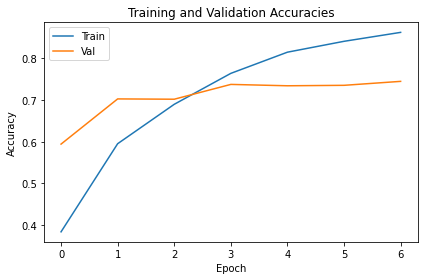

In [ ]:
plot_acc(history_2.history['accuracy'], history_2.history['val_accuracy'])

## Evaluation on the test dataset

In [ ]:
test_pred = model2.predict(test_text_padded)
test_pred = test_pred.round().astype(int)

In [ ]:
# transforming the pred vectors to its label:
test_pred_cat = np.zeros(test_pred.shape[0],)
test_labels_cat = np.zeros(test_pred.shape[0],)

for i in range(0,test_pred.shape[0],1):
  test_pred_cat[i] = test_pred[i].argmax()
  test_labels_cat[i] = test_labels[i].argmax()

test_pred_cat = test_pred_cat.astype(int)
test_labels_cat = test_labels_cat.astype(int)

In [ ]:
labels = {'Extremely Negative': 0,
          'Extremely Positive': 1,
          'Negative': 2,
          'Neutral': 3,
          'Positive': 4}
print(classification_report(test_labels_cat, test_pred_cat, target_names= labels.keys()))

                    precision    recall  f1-score   support

Extremely Negative       0.68      0.60      0.64       592
Extremely Positive       0.78      0.72      0.75       599
          Negative       0.61      0.69      0.65      1041
           Neutral       0.85      0.71      0.77       616
          Positive       0.63      0.70      0.67       947

          accuracy                           0.68      3795
         macro avg       0.71      0.68      0.69      3795
      weighted avg       0.69      0.68      0.69      3795



#Confusion matrix

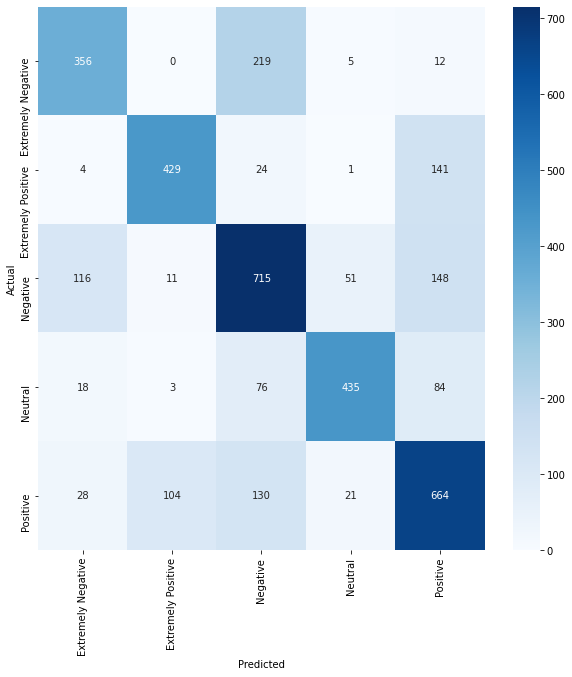

In [ ]:
conf_mat = confusion_matrix(test_labels_cat, test_pred_cat)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels.keys(), yticklabels=labels.keys(),cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()